# Apply PCA to plot a VN30-Index graph

The dataset used in this notebook is available at www.kaggle.com/datasets/nguyenngocphung/stock-prices-vn30-indexvietnam

This dataset provides stock prices of in total 30 indexes listed on VN30-Index. Each .csv file contains 7 features:
*   Ticker: Name of the index
*   DTYYYYMMDD: Trading date
*   Open: Opening price
*   High: Highest price
*   Low: Lowest price
*   Close: Closing Price
*   Volume: The number of stocks traded

=> To simplify the problem and focus more on PCA, I only use **Trading date** and **Closing price** to calculate VN30 Index (Of course, not in the way that it is suppossed to be).

# Data Preparation

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
drive.mount('/content/drive')

Mounted at /content/drive


Unfortunately, the number of observations varies across stocks, so I will choose the stock with the fewest observations to avoid missing values.

In [ ]:
df = pd.DataFrame()
data = pd.read_csv('/content/drive/MyDrive/VN30/TCB.csv')
df['Time'] = data['<DTYYYYMMDD>']
df

,Time
0,20210625
1,20210624
2,20210623
3,20210622
4,20210621
...,...
763,20180608
764,20180607
765,20180606
766,20180605


In [ ]:
def extract_close_from_csv(folder_path, df):
    os.chdir(folder_path)
    files = os.listdir()
    csv_files = [file for file in files if file.endswith('.csv')]

    for file in csv_files:
        data = pd.read_csv(file)
        data['<Close>'] = data['<Close>'].astype(float)
        name = os.path.splitext(file)[0]
        close_price = data['<Close>']
        df[name] = close_price

    return df

path = '/content/drive/MyDrive/VN30'
df = extract_close_from_csv(path, df)
df = df.iloc[::-1].reset_index(drop=True)

Quickly check throughout the dataset

In [ ]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(' MISSING VALUES '.center(70,'-'))
    print(dataframe.isnull().sum())
    print(' DUPLICATED VALUES '.center(70,'-'))
    print(dataframe.duplicated().sum())

check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 768
Columns: 31
------------------------------- TYPES --------------------------------
Time      int64
CTG     float64
GAS     float64
FPT     float64
BVH     float64
HPG     float64
HDB     float64
BID     float64
NVL     float64
PLX     float64
VJC     float64
VIC     float64
PNJ     float64
TPB     float64
VHM     float64
KDH     float64
VRE     float64
VCB     float64
SSI     float64
SBT     float64
POW     float64
REE     float64
TCH     float64
MWG     float64
TCB     float64
MBB     float64
STB     float64
MSN     float64
PDR     float64
VPB     float64
VNM     float64
dtype: object
-------------------------------- HEAD --------------------------------
       Time      CTG      GAS      FPT      BVH      HPG      HDB      BID  \
0  20180604  27.5559  81.8840  29.0245  91.0772  19.8304  31.8995  29.4947   
1  20180605  27.9996  87.5618  29.3624  91.0772  19.4999  32.0479  29.3980   
2  20180606  28.5419 

Transform 'Time' values into proper datetime datatype

In [ ]:
from datetime import datetime

df['Time'] = df['Time'].astype(str)
df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x, '%Y%m%d'))
print(df['Time'].head())

0   2018-06-04
1   2018-06-05
2   2018-06-06
3   2018-06-07
4   2018-06-08
Name: Time, dtype: datetime64[ns]


Split Stock values and Time

In [ ]:
time = df['Time'] # Select time
X = df.drop(columns=['Time']) # Select close prices
print(X.shape, time.shape)

(768, 30) (768,)


Normalization

In [ ]:
X_std = (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 1)

The formula to calculate VN30-Index is:

VN30-Index = CMV (Giá trị vốn hóa thị trường hiện tại) / BMV (Giá trị vốn hóa thị trường cơ sở) * 100

With:

CMV = Total of (Closing price * Volume) in a day => Here, I assumed CMV = Total of Closing price

BMV = CMV of the first day


In [ ]:
cmv = np.sum(X, axis=1) # Sum by rows
bmv = np.full(cmv.shape, cmv[0]) # Create an array with the shape of cmv and the value of each element equals to the 1st cmv
vn_index = cmv/bmv * 100
vn_index.head()

0    100.000000
1    101.175157
2    102.659944
3    102.952721
4    103.230955
dtype: float64

# PCA

In [ ]:
from sklearn.decomposition import PCA

# Use PCA with 30 components first to observe how much info they preserve
pca = PCA(random_state=0)
pca.fit(X_std)
eigenvals = pca.explained_variance_
cumsum = np.cumsum(eigenvals)
cumsum /= cumsum[-1]
cumsum

array([0.54632764, 0.75109487, 0.84509727, 0.88227815, 0.91257054,
       0.93521349, 0.95019603, 0.96199184, 0.97133621, 0.97692666,
       0.98034857, 0.98331635, 0.98589778, 0.98828068, 0.99032057,
       0.992171  , 0.9934397 , 0.99461741, 0.99564737, 0.99657394,
       0.99721091, 0.99775007, 0.99827998, 0.99871181, 0.99904501,
       0.99931384, 0.99955663, 0.99972707, 0.99988357, 1.        ])

In [ ]:
# With the result above, using only 1 PCA component we can preserve about 54,63% of the total information
X_pca = PCA(n_components=1, random_state=0).fit_transform(X_std.copy())

# Plotting

Since we're only using one component, which preserves approximately 54,63% of the data's information, my aim here is simply to visualize the dataset before and after PCA application and determine if it captures the underlying trend.

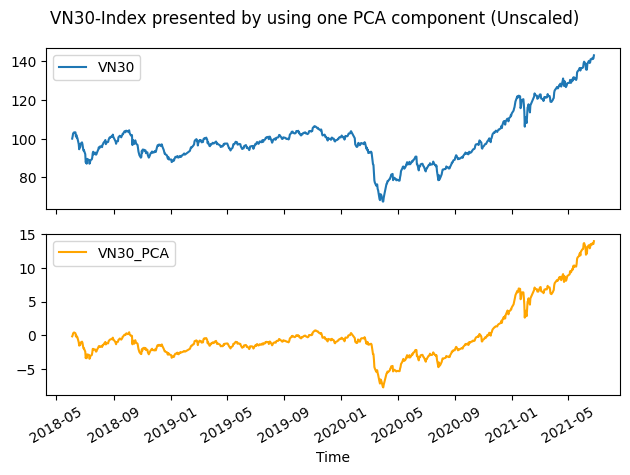

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('VN30-Index presented by using one PCA component (Unscaled)')
plt.xlabel('Time')
ax1.plot(time, vn_index, label = 'VN30')
ax1.legend()
ax1.label_outer()
ax2.plot(time, X_pca, label = 'VN30_PCA', color = 'orange')
ax2.legend()
plt.xticks(rotation=30)
fig.tight_layout()
plt.show()

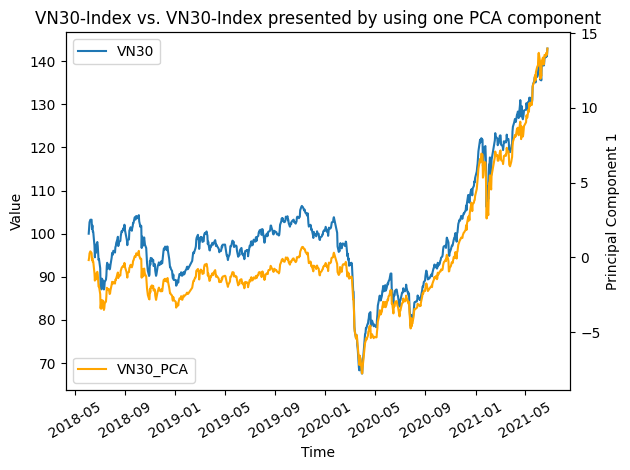

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(time, vn_index, label='VN30')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('VN30-Index vs. VN30-Index presented by using one PCA component')
ax1.legend()
plt.xticks(rotation=30)
ax2 = ax1.twinx()
ax2.plot(time, X_pca, color='orange', label='VN30_PCA')
ax2.set_ylabel('Principal Component 1')
ax2.set_xlabel('Time')
ax2.legend(loc='lower left')
fig.tight_layout()
plt.show()